# XGBoost

## Load Data

In [1]:
from pathlib import Path

import pandas as pd

In [2]:
from sklearn.utils import shuffle

base_directory = Path(r'/media/thor/PortableSSD/mydata/emojihero/dataset/dataset-face-expression-csv')
train_df = pd.read_csv(base_directory / 'training_set.csv')
val_df = pd.read_csv(base_directory / 'validation_set.csv')

SEED = 42
train_df = shuffle(train_df, random_state=SEED)
val_df = shuffle(val_df, random_state=SEED)

print(f'Number of Training Samples: {len(train_df)}')
print(train_df['Label'].value_counts())
print(f'Number of Validation Samples: {len(val_df)}')
print(val_df['Label'].value_counts())

train_df.head()

Number of Training Samples: 964
Label
0    197
1    191
3    172
2    131
4    105
5    102
6     66
Name: count, dtype: int64
Number of Validation Samples: 385
Label
5    55
4    55
1    55
2    55
6    55
0    55
3    55
Name: count, dtype: int64


,timestamp,participant_id,FAU_0,FAU_1,FAU_2,FAU_3,FAU_4,FAU_5,FAU_6,FAU_7,...,FAU_54,FAU_55,FAU_56,FAU_57,FAU_58,FAU_59,FAU_60,FAU_61,FAU_62,Label
760,1700488114760,3,0.107896,0.194889,1.401298e-45,1.320220e-22,0.024912,0.024321,1.401298e-45,1.401298e-45,...,9.209801e-21,2.610711e-37,1.000182e-13,5.099260e-05,1.002689e-02,4.672041e-07,2.050273e-07,5.688704e-02,8.172417e-02,4
884,1700748819058,16,0.834857,0.764817,1.026462e-20,2.168397e-11,0.416924,0.377339,2.632983e-03,1.401298e-45,...,2.479763e-03,2.194700e-01,2.563659e-01,1.888640e-06,5.865657e-03,8.533958e-10,2.958799e-04,1.071407e-02,2.710130e-02,5
938,1701357565849,34,0.131417,0.130338,1.680341e-04,1.439196e-04,0.252091,0.225658,0.000000e+00,0.000000e+00,...,1.401298e-45,1.083556e-02,1.089628e-02,2.802597e-45,1.980103e-34,1.401298e-45,1.401298e-45,2.718902e-01,2.924575e-01,5
901,1700827807807,21,0.615232,0.514535,9.174733e-03,9.058302e-03,0.389754,0.374438,0.000000e+00,0.000000e+00,...,2.141047e-02,9.831126e-01,9.945938e-01,8.538091e-03,4.727362e-02,9.986752e-05,4.469715e-06,3.522862e-01,4.055933e-01,5
622,1700748690839,16,0.000001,0.000020,1.059425e-02,1.085821e-02,0.010866,0.000002,1.401298e-45,0.000000e+00,...,7.473406e-12,5.651674e-10,1.086265e-02,1.238884e-02,9.620150e-03,1.538864e-01,1.280742e-01,1.139681e-12,6.957371e-13,3


In [3]:
import numpy as np
from sklearn.model_selection import PredefinedSplit

X_train = train_df.drop(['Label', 'timestamp', 'participant_id'], axis=1)
y_train = train_df['Label']
X_val = val_df.drop(['Label', 'timestamp', 'participant_id'], axis=1)
y_val = val_df['Label']
X_combined = pd.concat([X_train, X_val])
y_combined = pd.concat([y_train, y_val])

train_indices = -1 * np.ones(len(train_df), dtype=int)
val_indices = np.zeros(len(val_df), dtype=int)
split_index = np.concatenate((train_indices, val_indices))
ps = PredefinedSplit(split_index)

## Find optimal Hyperparameters via GridSearch

In [4]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(random_state=SEED))
])

# See: https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier
param_grid = {
    'xgb__learning_rate': [0.2, 0.3, 0.4],
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [4, 6, 8],
    'xgb__subsample': [1., 0.8],
    'xgb__colsample_bytree': [1., 0.8],
    'xgb__gamma': [0, 0.1,],
    'xgb__min_child_weight': [1, 2],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=ps, refit=False, scoring='accuracy', n_jobs=-1, verbose=2)

### Unbalanced

In [5]:
import time

start_time = time.time()
grid_search.fit(X_combined, y_combined)
end_time = time.time()

print(f'GridSearch took: {end_time - start_time:.2f} seconds.')

Fitting 1 folds for each of 432 candidates, totalling 432 fits
GridSearch took: 28.17 seconds.


In [6]:
best_unbalanced_parameters = grid_search.best_params_
best_unbalanced_val_acc = grid_search.best_score_
print('Best Parameters:', best_unbalanced_parameters)
print('Best Cross-Validation-Accuracy:', best_unbalanced_val_acc)
best_unbalanced_parameters = {k.replace('xgb__', ''): v for k, v in best_unbalanced_parameters.items()}

Best Parameters: {'xgb__colsample_bytree': 0.8, 'xgb__gamma': 0, 'xgb__learning_rate': 0.4, 'xgb__max_depth': 4, 'xgb__min_child_weight': 2, 'xgb__n_estimators': 200, 'xgb__subsample': 1.0}
Best Cross-Validation-Accuracy: 0.8155844155844156


### Balanced

In [7]:
from sklearn.utils import compute_sample_weight

sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)

In [8]:
start_time = time.time()
grid_search.fit(X_combined, y_combined, xgb__sample_weight=sample_weight)
end_time = time.time()

print(f'GridSearch took: {end_time - start_time:.4f} seconds.')

Fitting 1 folds for each of 432 candidates, totalling 432 fits
GridSearch took: 27.1887 seconds.


In [9]:
best_balanced_parameters = grid_search.best_params_
best_balanced_val_acc = grid_search.best_score_
print('Best Parameters:', best_balanced_parameters)
print('Best Cross-Validation-Accuracy:', best_balanced_val_acc)
best_balanced_parameters = {k.replace('xgb__', ''): v for k, v in best_balanced_parameters.items()}

Best Parameters: {'xgb__colsample_bytree': 1.0, 'xgb__gamma': 0, 'xgb__learning_rate': 0.4, 'xgb__max_depth': 4, 'xgb__min_child_weight': 2, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}
Best Cross-Validation-Accuracy: 0.8103896103896104


## Evaluation

In [10]:
if best_balanced_val_acc >= best_unbalanced_val_acc:

    best_model = Pipeline([
        ('scaler', StandardScaler()),
        ('xgb', XGBClassifier(**best_balanced_parameters, random_state=SEED))
    ])
    best_model.fit(X_train, y_train, xgb__sample_weight=sample_weight)
    print(
        f'Trained balanced model because {best_balanced_val_acc:.4f} is greater or equal than {best_unbalanced_val_acc:.4f}')

else:

    best_model = Pipeline([
        ('scaler', StandardScaler()),
        ('xgb', XGBClassifier(**best_unbalanced_parameters, random_state=SEED))
    ])
    best_model.fit(X_train, y_train)
    print(f'Trained unbalanced model because {best_unbalanced_val_acc:.4f} is greater than {best_balanced_val_acc:.4f}')


Trained unbalanced model because 0.8156 is greater than 0.8104


In [11]:
from sklearn.metrics import accuracy_score

y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy with optimized Hyperparameters: {val_accuracy:.4f}")

Validation Accuracy with optimized Hyperparameters: 0.8156


In [12]:
test_df = pd.read_csv(base_directory / 'test_set.csv')
print(f'Number of Test Samples: {len(test_df)}')
X_test, y_test = test_df.drop(['Label', 'timestamp', 'participant_id'], axis=1), test_df['Label']

Number of Test Samples: 378


In [13]:
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy with optimized Hyperparameters: {test_accuracy:.4f}")

Test Accuracy with optimized Hyperparameters: 0.7011


In [14]:
from sklearn.metrics import classification_report

emotion_to_id = {'Neutral': 0, 'Happiness': 1, 'Sadness': 2, 'Surprise': 3, 'Fear': 4, 'Disgust': 5, 'Anger': 6}

print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=emotion_to_id.keys(), digits=4))

Classification Report (Test Set):
              precision    recall  f1-score   support

     Neutral     0.7679    0.7963    0.7818        54
   Happiness     0.7681    0.9815    0.8618        54
     Sadness     0.8913    0.7593    0.8200        54
    Surprise     0.7719    0.8148    0.7928        54
        Fear     0.6296    0.6296    0.6296        54
     Disgust     0.4429    0.5741    0.5000        54
       Anger     0.7308    0.3519    0.4750        54

    accuracy                         0.7011       378
   macro avg     0.7146    0.7011    0.6944       378
weighted avg     0.7146    0.7011    0.6944       378



Confusion Matrix, without normalization
[[43  3  1  0  6  1  0]
 [ 0 53  0  0  0  1  0]
 [ 6  0 41  0  4  1  2]
 [ 0  0  1 44  6  3  0]
 [ 4  3  0  8 34  5  0]
 [ 0  8  3  4  3 31  5]
 [ 3  2  0  1  1 28 19]]


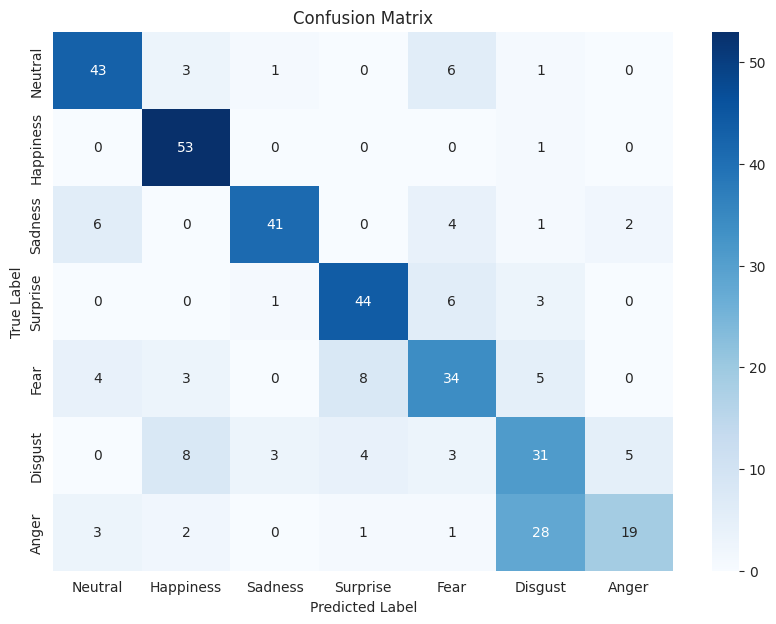

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np


def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


plot_confusion_matrix(y_test, y_test_pred, classes=emotion_to_id.keys(), title='Confusion Matrix')